# CSE6250BDH FINAL PROJECT
## Predicting Heart Failure Readmission from Clinical Notes Using Deep Learning (CNN)


In [2]:
import torch
import pandas as pd
import numpy as np
import datetime
import builtins
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from gensim.models import KeyedVectors
import nltk
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer 
from nltk.corpus import stopwords
from string import punctuation
import time
import os
import psutil
from utility import *
from torch.utils.data import TensorDataset, Dataset
import torch.optim as optim

from sklearn.model_selection import train_test_split



nltk.download('stopwords')
nltk.download('punkt')

n_cores = psutil.cpu_count(logical=False)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ssiddiqui\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ssiddiqui\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
print(f"number of cores: {n_cores}")
print(torch.__version__)

number of cores: 8
2.0.0+cu118


In [4]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)


True
1
0
Quadro RTX 4000
Using device: cuda


In [5]:
#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Quadro RTX 4000
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [6]:
def custom_print(*args, **kwargs):
    now = datetime.now()
    dt_string = now.strftime("%Y/%m/%d %H:%M:%S")
    builtins.print(f"[{dt_string}] -", *args, **kwargs)

# Override the built-in print function
print = custom_print    

# Restore the original print function
#print = builtins.print


# DATA PRE-PROCESSING

In [7]:
stop_words = set(stopwords.words('english'))
pattern = r'\b[a-zA-Z]+\b' # regex pattern for matching words only
regex_tokenizer = RegexpTokenizer(pattern)
#regex_tokenizer = RegexpTokenizer(r'\w+') # \w+ tokenizes the input text into words, extracting sequences of alphanumeric characters as tokens and ignoring punctuations and whitespace.


def preprocess_sentence(text):
    text = text.replace('/', ' / ')
    text = text.replace('.-', ' .- ')
    text = text.replace('.', ' . ')
    text = text.replace('\'', ' \' ')
    text = text.lower()

    

    tokens = [token for token in regex_tokenizer.tokenize(text) 
             if token not in punctuation and 
             token not in stop_words
            ]

    
    processed_text = ' '.join(tokens).replace('unit numeric identifier', '') \
                                     .replace('admission date', '') \
                                     .replace('discharge date', '')\
                                     .replace('date birth', '')

    return processed_text.strip()

In [8]:
hf_admission_notes_with_labels = pd.read_csv('.\data\mimic_hf_admission_notes_with_readmission_labels.csv')

hf_admission_notes_with_labels.shape

(13746, 7)

In [9]:
hf_admission_notes_with_labels.head()

,HADM_ID,SUBJECT_ID,TEXT,DESCRIPTION,ADMITTIME,READMISSION,READMISSION_30DAYS
0,138376,124,Unit No: [**Numeric Identifier 13036**]\nAdmi...,Report,2165-12-31 18:55:00,0,0
1,138523,89292,Admission Date: [**2169-12-23**] ...,Report,2169-12-23 20:05:00,0,0
2,152398,1351,Admission Date: [**2188-5-3**] D...,Report,2188-05-03 12:39:00,0,0
3,107779,15048,Admission Date: [**2195-9-24**] Discharge...,Report,2195-09-24 16:38:00,0,0
4,129665,55611,Admission Date: [**2172-4-13**] ...,Report,2172-04-13 19:06:00,0,0


In [10]:
len(hf_admission_notes_with_labels.iloc[0,2].split(" "))

839

In [11]:
hf_admission_notes_with_labels[["READMISSION","READMISSION_30DAYS"]].agg(["sum","count"])

,READMISSION,READMISSION_30DAYS
sum,3543,962
count,13746,13746


### TOKENIZE AND PROCESS CLINICAL NOTES

In [12]:
hf_admission_notes_with_labels['TEXT_LEN'] = hf_admission_notes_with_labels['TEXT'].apply(lambda words: len(words.split(" ")))
hf_admission_notes_with_labels['TOKENIZED_PROCESSED_TEXT'] = hf_admission_notes_with_labels['TEXT'].apply(lambda words: preprocess_sentence(words))
hf_admission_notes_with_labels['TOKENIZED_PROCESSED_TEXT_LEN'] = hf_admission_notes_with_labels['TOKENIZED_PROCESSED_TEXT'].apply(lambda words: len(words.split(" ")))

hf_admission_notes_with_labels.head()
#hf_admission_notes_with_labels.sort_values("TEXT_LEN",ascending=False).head()

,HADM_ID,SUBJECT_ID,TEXT,DESCRIPTION,ADMITTIME,READMISSION,READMISSION_30DAYS,TEXT_LEN,TOKENIZED_PROCESSED_TEXT,TOKENIZED_PROCESSED_TEXT_LEN
0,138376,124,Unit No: [**Numeric Identifier 13036**]\nAdmi...,Report,2165-12-31 18:55:00,0,0,839,sex service admission diagnosis pneumonia colo...,511
1,138523,89292,Admission Date: [**2169-12-23**] ...,Report,2169-12-23 20:05:00,0,0,3668,sex service medicine allergies known allergies...,2596
2,152398,1351,Admission Date: [**2188-5-3**] D...,Report,2188-05-03 12:39:00,0,0,1658,sex service medicine allergies penicillins att...,1165
3,107779,15048,Admission Date: [**2195-9-24**] Discharge...,Report,2195-09-24 16:38:00,0,0,669,service company medicine outside hospital panc...,436
4,129665,55611,Admission Date: [**2172-4-13**] ...,Report,2172-04-13 19:06:00,0,0,2431,sex service medicine allergies known allergies...,1726


In [13]:
hf_admission_notes_with_labels.iloc[1,8]

'sex service medicine allergies known allergies adverse drug reactions attending first lf chief complaint shock major surgical invasive procedure thoracentesis bronchoscopy history present illness yo h moderate copd afib coumadin schf transferred location un ed ed management septic shock respiratory failure per patient three sons noted feel sob tired past days morning called ex wife drive name ni feeling unwell location un found hypotensive sbp hr due concern pna cxr given ceftriaxone given liters ns started dopamine levophed continued sbps femoral line placed labs notable wbc eosinophilia due finding given mg hydrocortisone k elevated cr elevated bl bun inr lactate guaiac negative given cacl insulin amp also intubated tachypnea hypoxia started fentanyl versed uop cc total vs prior transfer bp hr ed initial vs degrees c rectal dopamine levophed ac given vancomycin zosyn well liters ns line placed also g ivs ct torso show obvious catastrophy echo performed cards show wall motion abnorma

[2023/11/13 18:59:05] - Avg Tokenized & Processed Notes Length: 1157.3649789029537
[2023/11/13 18:59:05] - Max Tokenized & Processed Notes Length: 4650
[2023/11/13 18:59:05] - Min Tokenized & Processed Notes Length: 24
[2023/11/13 18:59:05] - Std Tokenized & Processed Notes Length: 506.20113787888295
[2023/11/13 18:59:05] - 2676


,HADM_ID,SUBJECT_ID,TEXT,DESCRIPTION,ADMITTIME,READMISSION,READMISSION_30DAYS,TEXT_LEN,TOKENIZED_PROCESSED_TEXT,TOKENIZED_PROCESSED_TEXT_LEN
0,138376,124,Unit No: [**Numeric Identifier 13036**]\nAdmi...,Report,2165-12-31 18:55:00,0,0,839,sex service admission diagnosis pneumonia colo...,511
1,138523,89292,Admission Date: [**2169-12-23**] ...,Report,2169-12-23 20:05:00,0,0,3668,sex service medicine allergies known allergies...,2596
2,152398,1351,Admission Date: [**2188-5-3**] D...,Report,2188-05-03 12:39:00,0,0,1658,sex service medicine allergies penicillins att...,1165
3,107779,15048,Admission Date: [**2195-9-24**] Discharge...,Report,2195-09-24 16:38:00,0,0,669,service company medicine outside hospital panc...,436
4,129665,55611,Admission Date: [**2172-4-13**] ...,Report,2172-04-13 19:06:00,0,0,2431,sex service medicine allergies known allergies...,1726


c:\Users\ssiddiqui\OneDrive\Education\GT-OMSA\CSE-6250-Big-Data-Health\Project\BD4H_FINAL\bd4h_final_proj\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ssiddiqui\OneDrive\Education\GT-OMSA\CSE-6250-Big-Data-Health\Project\BD4H_FINAL\bd4h_final_proj\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


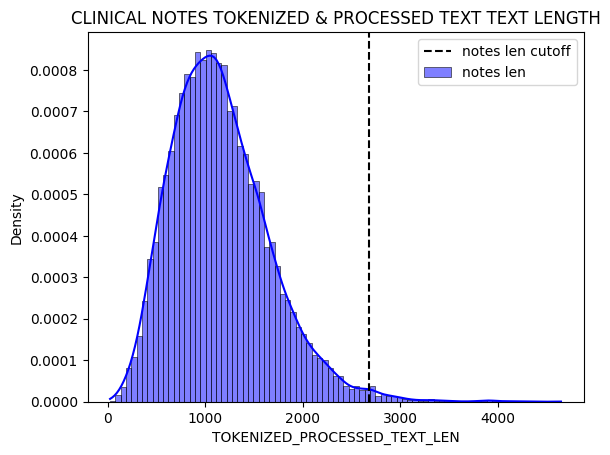

In [14]:
hf_admission_notes_with_labels["TOKENIZED_PROCESSED_TEXT_LEN"].max()

#rule of thumb from statistics that approximately 99.7% of data points in a normally distributed dataset lie within three standard deviations of the mean
notes_len_cutoff = np.round(hf_admission_notes_with_labels['TOKENIZED_PROCESSED_TEXT_LEN'].mean() + 3*hf_admission_notes_with_labels['TOKENIZED_PROCESSED_TEXT_LEN'].std()).astype(int) 


#Instead of using the mean and standard deviation, consider using the median and interquartile range (IQR) to set max_seq_len,
# since the median and IQR are more robust to skewed data and outliers.

#q75, q25 = np.percentile(hf_admission_notes_with_labels['TEXT_LEN'], [75 ,25])
#iqr = q75 - q25
#max_seq_len = np.round(q75 + (1.5 * iqr)).astype(int) # Adjust 1.5 based on how inclusive you want to be of the outlier data.
#max_seq_len

print(f"Avg Tokenized & Processed Notes Length: {hf_admission_notes_with_labels['TOKENIZED_PROCESSED_TEXT_LEN'].mean()}")
print(f"Max Tokenized & Processed Notes Length: {hf_admission_notes_with_labels['TOKENIZED_PROCESSED_TEXT_LEN'].max()}")
print(f"Min Tokenized & Processed Notes Length: {hf_admission_notes_with_labels['TOKENIZED_PROCESSED_TEXT_LEN'].min()}")
print(f"Std Tokenized & Processed Notes Length: {hf_admission_notes_with_labels['TOKENIZED_PROCESSED_TEXT_LEN'].std()}")
print(notes_len_cutoff)
display(hf_admission_notes_with_labels.head(5))

#https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751
sns.histplot(hf_admission_notes_with_labels['TOKENIZED_PROCESSED_TEXT_LEN'], kde=True, stat="density", color='b', label='notes len')
plt.axvline(x=notes_len_cutoff, color='k', linestyle='--', label='notes len cutoff')
plt.title('CLINICAL NOTES TOKENIZED & PROCESSED TEXT TEXT LENGTH'); plt.legend()
plt.show()


## DOWNSAMPLE THE MAJORITY CLASS TO MATCH READMISSION SAMPLES 

### BALANCED SAMPLE DATASET

In [15]:

# Separate majority and minority classes
hf_readmission_notes_majority = hf_admission_notes_with_labels[hf_admission_notes_with_labels.READMISSION == 0]
hf_readmission_notes_minority = hf_admission_notes_with_labels[hf_admission_notes_with_labels.READMISSION == 1]
# Downsample majority class
hf_readmission_notes_majority_downsampled = hf_readmission_notes_majority.sample(n=len(hf_readmission_notes_minority), random_state=42)
# Combine minority class with downsampled majority class
hf_readmission_notes_balanced = pd.concat([hf_readmission_notes_majority_downsampled, hf_readmission_notes_minority])

print(hf_readmission_notes_balanced.READMISSION.value_counts())

# Shuffle the dataset to prevent the model from learning any order
hf_readmission_notes_balanced = hf_readmission_notes_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

fraction = 0.4  # For example, 10% of each class
hf_readmission_notes_balanced = hf_readmission_notes_balanced.groupby('READMISSION', group_keys=False).apply(lambda x: x.sample(frac=fraction))


# Display new class counts
print(hf_readmission_notes_balanced.READMISSION.value_counts())

[2023/11/13 18:59:06] - READMISSION
0    3543
1    3543
Name: count, dtype: int64
[2023/11/13 18:59:06] - READMISSION
0    1417
1    1417
Name: count, dtype: int64


[2023/11/13 18:59:06] - Avg Tokenized & Processed Notes Length: 1180.516584333098
[2023/11/13 18:59:06] - Max Tokenized & Processed Notes Length: 3977
[2023/11/13 18:59:06] - Min Tokenized & Processed Notes Length: 91
[2023/11/13 18:59:06] - Std Tokenized & Processed Notes Length: 499.52987772155456
[2023/11/13 18:59:06] - 2953


,HADM_ID,SUBJECT_ID,TEXT,DESCRIPTION,ADMITTIME,READMISSION,READMISSION_30DAYS,TEXT_LEN,TOKENIZED_PROCESSED_TEXT,TOKENIZED_PROCESSED_TEXT_LEN
830,119203,42,Admission Date: [**2116-4-29**] Dischar...,Report,2116-04-26 18:58:00,0,0,1242,sex service ccu history present illness patien...,644
4225,104448,17709,Admission Date: [**2197-11-10**] ...,Report,2197-11-10 18:21:00,0,0,768,sex f service cardiothoracic allergies patient...,623
4014,126522,30890,Admission Date: [**2194-7-31**] ...,Report,2194-07-31 22:30:00,0,0,1423,sex f service medicine allergies patient recor...,976
4222,136079,14994,Admission Date: [**2136-8-13**] ...,Report,2136-08-13 06:23:00,0,0,1386,service med allergies patient recorded known a...,1035
1826,149291,2734,Admission Date: [**2109-4-16**] ...,Report,2109-04-16 03:53:00,0,0,1402,sex service medicine allergies c e inhibitors ...,974


c:\Users\ssiddiqui\OneDrive\Education\GT-OMSA\CSE-6250-Big-Data-Health\Project\BD4H_FINAL\bd4h_final_proj\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ssiddiqui\OneDrive\Education\GT-OMSA\CSE-6250-Big-Data-Health\Project\BD4H_FINAL\bd4h_final_proj\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


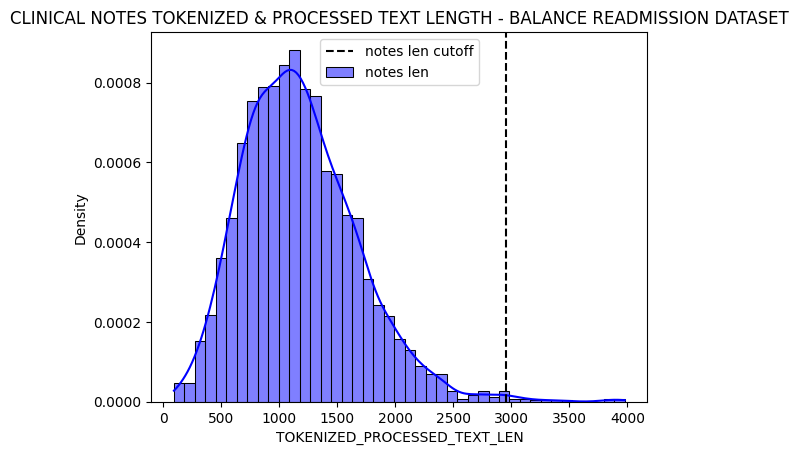

In [16]:
#rule of thumb from statistics that approximately 99.7% of data points in a normally distributed dataset lie within three standard deviations of the mean
#readmission_notes_len_cutoff = np.round(hf_readmission_notes_balanced['TEXT_LEN'].mean() + 3*hf_readmission_notes_balanced['TEXT_LEN'].std()).astype(int) 
#print(readmission_notes_len_cutoff)

#Instead of using the mean and standard deviation, consider using the median and interquartile range (IQR) to set max_seq_len,
# since the median and IQR are more robust to skewed data and outliers.

q85, q25 = np.percentile(hf_admission_notes_with_labels['TOKENIZED_PROCESSED_TEXT_LEN'], [85 ,25])
iqr = q85 - q25
readmission_notes_len_cutoff = np.round(q85 + (1.5 * iqr)).astype(int) # Adjust 1.5 based on how inclusive you want to be of the outlier data.


print(f"Avg Tokenized & Processed Notes Length: {hf_readmission_notes_balanced['TOKENIZED_PROCESSED_TEXT_LEN'].mean()}")
print(f"Max Tokenized & Processed Notes Length: {hf_readmission_notes_balanced['TOKENIZED_PROCESSED_TEXT_LEN'].max()}")
print(f"Min Tokenized & Processed Notes Length: {hf_readmission_notes_balanced['TOKENIZED_PROCESSED_TEXT_LEN'].min()}")
print(f"Std Tokenized & Processed Notes Length: {hf_readmission_notes_balanced['TOKENIZED_PROCESSED_TEXT_LEN'].std()}")
print(readmission_notes_len_cutoff)
display(hf_readmission_notes_balanced.head(5))

#https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751
sns.histplot(hf_readmission_notes_balanced['TOKENIZED_PROCESSED_TEXT_LEN'], kde=True, stat="density", color='b', label='notes len')
plt.axvline(x=readmission_notes_len_cutoff, color='k', linestyle='--', label='notes len cutoff')
plt.title('CLINICAL NOTES TOKENIZED & PROCESSED TEXT LENGTH - BALANCE READMISSION DATASET'); 
plt.legend()
plt.show()


## DOWNSAMPLE THE MAJORITY CLASS TO 30-DAY READMISSION SAMPLE 
### BALANCED SAMPLE DATASET

In [17]:

# Separate majority and minority classes
hf_30day_readmission_notes_majority = hf_admission_notes_with_labels[hf_admission_notes_with_labels.READMISSION_30DAYS == 0]
hf_30day_readmission_notes_minority = hf_admission_notes_with_labels[hf_admission_notes_with_labels.READMISSION_30DAYS == 1]
# Downsample majority class
hf_30day_readmission_notes_majority_downsampled = hf_30day_readmission_notes_majority.sample(n=len(hf_30day_readmission_notes_minority), random_state=42)
# Combine minority class with downsampled majority class
hf_30day_readmission_notes_balanced = pd.concat([hf_30day_readmission_notes_majority_downsampled, hf_30day_readmission_notes_minority])
# Shuffle the dataset to prevent the model from learning any order
hf_30day_readmission_notes_balanced = hf_30day_readmission_notes_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
# Display new class counts
print(hf_30day_readmission_notes_balanced.READMISSION_30DAYS.value_counts())

[2023/11/13 18:59:06] - READMISSION_30DAYS
1    962
0    962
Name: count, dtype: int64


[2023/11/13 18:59:07] - Avg Tokenized & Processed Notes Length: 1243.0031185031185
[2023/11/13 18:59:07] - Max Tokenized & Processed Notes Length: 4147
[2023/11/13 18:59:07] - Min Tokenized & Processed Notes Length: 137
[2023/11/13 18:59:07] - Std Tokenized & Processed Notes Length: 513.3587127506346
[2023/11/13 18:59:07] - 3000


,HADM_ID,SUBJECT_ID,TEXT,DESCRIPTION,ADMITTIME,READMISSION,READMISSION_30DAYS,TEXT_LEN,TOKENIZED_PROCESSED_TEXT,TOKENIZED_PROCESSED_TEXT_LEN
0,165332,32348,Admission Date: [**2145-7-13**] ...,Report,2145-07-13 00:59:00,1,1,1985,sex service medicine allergies clonidine atten...,1366
1,170535,30348,Admission Date: [**2185-12-28**] ...,Report,2185-12-28 13:15:00,1,1,1215,service medicine allergies sulfa sulfonamides ...,855
2,111925,69265,Admission Date: [**2194-5-15**] ...,Report,2194-05-15 17:42:00,0,0,2478,sex service medicine allergies known allergies...,1328
3,128989,27043,Admission Date: [**2141-10-21**] ...,Report,2141-10-21 06:35:00,0,0,1682,sex service medicine allergies patient recorde...,1233
4,147206,75031,Admission Date: [**2198-3-28**] ...,Report,2198-03-28 01:09:00,0,0,2592,sex service medicine allergies patient recorde...,1677


c:\Users\ssiddiqui\OneDrive\Education\GT-OMSA\CSE-6250-Big-Data-Health\Project\BD4H_FINAL\bd4h_final_proj\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ssiddiqui\OneDrive\Education\GT-OMSA\CSE-6250-Big-Data-Health\Project\BD4H_FINAL\bd4h_final_proj\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


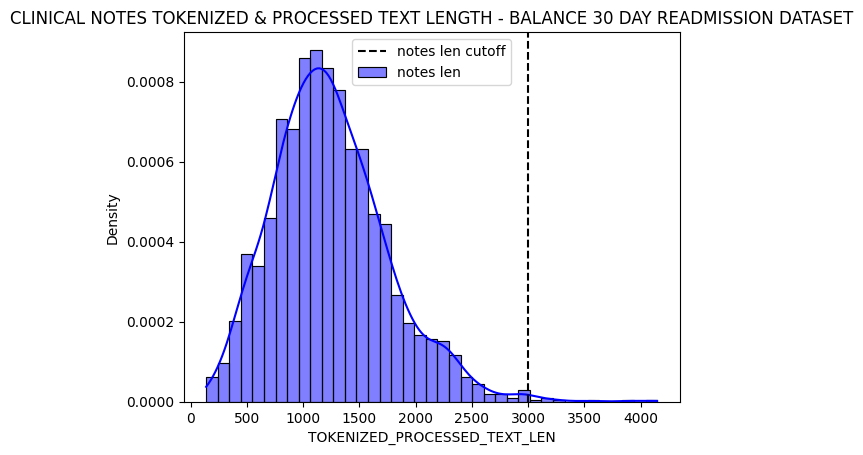

In [18]:
#rule of thumb from statistics that approximately 99.7% of data points in a normally distributed dataset lie within three standard deviations of the mean
#max_text_len_readmission = np.round(hf_readmission_notes_balanced['TEXT_LEN'].mean() + 3*hf_readmission_notes_balanced['TEXT_LEN'].std()).astype(int) 
#print(max_text_len_readmission)

#Instead of using the mean and standard deviation, consider using the median and interquartile range (IQR) to set max_seq_len,
# since the median and IQR are more robust to skewed data and outliers.

q85, q25 = np.percentile(hf_30day_readmission_notes_balanced['TOKENIZED_PROCESSED_TEXT_LEN'], [85 ,25])
iqr = q85 - q25
_30dayreadmission_notes_cutoff = np.round(q85 + (1.5 * iqr)).astype(int) # Adjust 1.5 based on how inclusive you want to be of the outlier data.


print(f"Avg Tokenized & Processed Notes Length: {hf_30day_readmission_notes_balanced['TOKENIZED_PROCESSED_TEXT_LEN'].mean()}")
print(f"Max Tokenized & Processed Notes Length: {hf_30day_readmission_notes_balanced['TOKENIZED_PROCESSED_TEXT_LEN'].max()}")
print(f"Min Tokenized & Processed Notes Length: {hf_30day_readmission_notes_balanced['TOKENIZED_PROCESSED_TEXT_LEN'].min()}")
print(f"Std Tokenized & Processed Notes Length: {hf_30day_readmission_notes_balanced['TOKENIZED_PROCESSED_TEXT_LEN'].std()}")
print(_30dayreadmission_notes_cutoff)
display(hf_30day_readmission_notes_balanced.head(5))

#https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751
sns.histplot(hf_30day_readmission_notes_balanced['TOKENIZED_PROCESSED_TEXT_LEN'], kde=True, stat="density", color='b', label='notes len')
plt.axvline(x=_30dayreadmission_notes_cutoff, color='k', linestyle='--', label='notes len cutoff')
plt.title('CLINICAL NOTES TOKENIZED & PROCESSED TEXT LENGTH - BALANCE 30 DAY READMISSION DATASET'); plt.legend()
plt.show()


## SPLIT DATA IN TRAIN TEST

### READMISSION BALANCED DATASET 90/10 SPLIT 

In [19]:
## READMISSION BALANCED DATASET 90/10 SPLIT 
readmission_notes_features = hf_readmission_notes_balanced[["TOKENIZED_PROCESSED_TEXT"]]
readmission_notes_target = hf_readmission_notes_balanced["READMISSION"]
X_readmission_train, X_readmission_test, y_readmission_train, y_readmission_test = train_test_split(readmission_notes_features, readmission_notes_target, test_size=0.1, random_state=42)

print(f"readmission_notes_features Shape: {readmission_notes_features.shape}")
print(f"X_readmission_train Shape: {X_readmission_train.shape}")
print(f"X_readmission_test Shape: {X_readmission_test.shape}")
print(f"y_readmission_train Shape: {y_readmission_train.shape}")
print(f"y_readmission_test Shape: {y_readmission_test.shape}")


[2023/11/13 18:59:07] - readmission_notes_features Shape: (2834, 1)
[2023/11/13 18:59:07] - X_readmission_train Shape: (2550, 1)
[2023/11/13 18:59:07] - X_readmission_test Shape: (284, 1)
[2023/11/13 18:59:07] - y_readmission_train Shape: (2550,)
[2023/11/13 18:59:07] - y_readmission_test Shape: (284,)


In [20]:
## 30-DAY READMISSION BALANCED DATASET 90/10 SPLIT 
_30day_readmission_notes_features = hf_30day_readmission_notes_balanced[["TOKENIZED_PROCESSED_TEXT"]]
_30day_readmission_notes_target = hf_30day_readmission_notes_balanced["READMISSION_30DAYS"]
X_30day_readmission_train, X_30day_readmission_test, y_30day_readmission_train, y_30day_readmission_test = train_test_split(_30day_readmission_notes_features, _30day_readmission_notes_target, test_size=0.1, random_state=42)

print(f"readmission_notes_features Shape: {_30day_readmission_notes_features.shape}")
print(f"X_readmission_train Shape: {X_30day_readmission_train.shape}")
print(f"X_readmission_test Shape: {X_30day_readmission_test.shape}")
print(f"y_readmission_train Shape: {y_30day_readmission_train.shape}")
print(f"y_readmission_test Shape: {y_30day_readmission_test.shape}")

[2023/11/13 18:59:07] - readmission_notes_features Shape: (1924, 1)
[2023/11/13 18:59:07] - X_readmission_train Shape: (1731, 1)
[2023/11/13 18:59:07] - X_readmission_test Shape: (193, 1)
[2023/11/13 18:59:07] - y_readmission_train Shape: (1731,)
[2023/11/13 18:59:07] - y_readmission_test Shape: (193,)


# LOAD PUBMED & PMC WORD2VEC MODEL INTO MEMORY

In [21]:
# Load the Word2Ven model (substitute with the path to your downloaded vectors)
# The model can be downloaded from: https://bio.nlplab.org/#word-vector-tools
# Word vectors > http://evexdb.org/pmresources/vec-space-models/
#PubMed abstract and PMC full text vector model  = './vector_embeddings/PubMed-and-PMC-w2v.bin'

## This is large file, I did not check into Github repository, please download it from the above location and place it in vector_embeddings folder

start_time = time.time()
pubmed_pmc_wordvector_path = './vector_embeddings/PubMed-and-PMC-w2v.bin'
pubmed_pmc_wordvector = KeyedVectors.load_word2vec_format(pubmed_pmc_wordvector_path, binary=True)
end_time = time.time()
pubmed_pmc_wordvector_model_load_elapsed_time = round(end_time - start_time,4)
print(f'PubMed & PMC vector model was successfully loaded in {utility.parse_time(pubmed_pmc_wordvector_model_load_elapsed_time)}')

[2023/11/13 18:59:32] - PubMed & PMC vector model was successfully loaded in 23.97 sec


In [22]:
pubmed_pmc_wordvector.vector_size

200

In [23]:
## 200 dimension vector embeddings
len(pubmed_pmc_wordvector["in"])

200

In [24]:

def get_embedding_vector(word, model):
    # This function returns the embedding vector for a word from the pre-trained model
    try:
        return model[word]
    except KeyError:
        # If the word is not in the model, return a zero vector
        return np.zeros(model.vector_size)

# Initialize an empty list to hold all record embeddings
X_readmission_train_embeddings = []

# Iterate over each record in the DataFrame
for _, row in X_readmission_train.iterrows():
    # Initialize the embedding matrix for this record with zeros
    notes_embedding_matrix = np.zeros((readmission_notes_len_cutoff, pubmed_pmc_wordvector.vector_size))
    
    # Iterate over the tokenized words up to the fixed_length
    for i, word in enumerate(row['TOKENIZED_PROCESSED_TEXT'][:readmission_notes_len_cutoff]):
        # Get the embedding vector for the word
        notes_embedding_matrix[i] = get_embedding_vector(word, pubmed_pmc_wordvector)
    
    # Add the record's embedding matrix to the list
    X_readmission_train_embeddings.append(notes_embedding_matrix)

# Convert the list of embeddings into a 3D NumPy array
X_readmission_train_embedding_stacked = np.stack(X_readmission_train_embeddings)
print(X_readmission_train_embedding_stacked.shape)
# Now `embedding_tensor` is a 3D tensor of shape (number_of_records, fixed_length, embedding_dimension)


[2023/11/13 18:59:49] - (2550, 2953, 200)


In [ ]:
# Initialize an empty list to hold all record embeddings
X_readmission_test_embeddings = []

# Iterate over each record in the DataFrame
for _, row in X_readmission_test.iterrows():
    # Initialize the embedding matrix for this record with zeros
    notes_embedding_matrix = np.zeros((readmission_notes_len_cutoff, pubmed_pmc_wordvector.vector_size))
    
    # Iterate over the tokenized words up to the fixed_length
    for i, word in enumerate(row['TOKENIZED_PROCESSED_TEXT'][:readmission_notes_len_cutoff]):
        # Get the embedding vector for the word
        notes_embedding_matrix[i] = get_embedding_vector(word, pubmed_pmc_wordvector)
    
    # Add the record's embedding matrix to the list
    X_readmission_test_embeddings.append(notes_embedding_matrix)

# Convert the list of embeddings into a 3D NumPy array
X_readmission_test_embedding_stacked = np.stack(X_readmission_test_embeddings)
print(X_readmission_test_embedding_stacked.shape)


In [26]:
readmission_notes_len_cutoff

2953

In [30]:
X_readmission_train_embedding_tensor = torch.from_numpy(X_readmission_train_embedding_stacked).unsqueeze(1)
#target = torch.from_numpy(target.astype('long')).view(-1,1)
train_target_readmission = torch.from_numpy(y_readmission_train.values)
readmission_train_dataset = TensorDataset(X_readmission_train_embedding_tensor, train_target_readmission)
X_readmission_train_embedding_tensor.shape

torch.Size([2550, 1, 2953, 200])

In [31]:
for i in range(min(5, len(readmission_train_dataset))):
    embedding, label = readmission_train_dataset[i]
    print(f"Embedding: {embedding.shape}, Label: {label}")

[2023/11/13 19:03:06] - Embedding: torch.Size([1, 2953, 200]), Label: 1
[2023/11/13 19:03:06] - Embedding: torch.Size([1, 2953, 200]), Label: 1
[2023/11/13 19:03:06] - Embedding: torch.Size([1, 2953, 200]), Label: 1
[2023/11/13 19:03:06] - Embedding: torch.Size([1, 2953, 200]), Label: 0
[2023/11/13 19:03:06] - Embedding: torch.Size([1, 2953, 200]), Label: 1


In [ ]:
X_readmission_test_embedding_tensor = torch.from_numpy(X_readmission_test_embedding_stacked).unsqueeze(1)
#target = torch.from_numpy(target.astype('long')).view(-1,1)
test_target_readmission = torch.from_numpy(y_readmission_test.values)
readmission_test_dataset = TensorDataset(X_readmission_test_embedding_tensor, test_target_readmission)
X_readmission_test_embedding_tensor.shape

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ReadmissionCNN(nn.Module):
    def __init__(self, n_filters, filter_sizes, output_dim, dropout, embedding_dim):
        super().__init__()
        
        # Since we already have embeddings, we won't use an embedding layer
        # self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # Convolutional layers with in_channels=1 because our input is not an image but an embedded text
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels=1,
                                              out_channels=n_filters,
                                              kernel_size=(fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
        
        # Fully connected layer
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout)

    def forward(self, embedded):
        # embedded is already a tensor with size [batch size, notes len, emb dim]
        # We add an extra dimension for the "channel" which is 1 here
        #embedded = embedded.unsqueeze(1)
        # embedded = [batch size, 1, notes len, emb dim]
        
        # Convolution and pooling layers
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        # conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
        
        # Max pooling over time
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        # pooled_n = [batch size, n_filters]
        
        # Concatenate the pooled features from different filter sizes
        cat = self.dropout(torch.cat(pooled, dim=1))
        # cat = [batch size, n_filters * len(filter_sizes)]
        
        # Fully connected layer
        return self.fc(cat)

class AverageMeter(object):
	"""Computes and stores the average and current value"""

	def __init__(self):
		self.reset()

	def reset(self):
		self.val = 0
		self.avg = 0
		self.sum = 0
		self.count = 0

	def update(self, val, n=1):
		self.val = val
		self.sum += val * n
		self.count += n
		self.avg = self.sum / self.count




In [ ]:
def compute_batch_accuracy(output, target):
	"""Computes the accuracy for a batch"""
	with torch.no_grad():

		batch_size = target.size(0)
		_, pred = output.max(1)
		correct = pred.eq(target).sum()

		return correct * 100.0 / batch_size    
	
def train(model, device, data_loader, criterion, optimizer, epoch, print_freq=10):
	batch_time = AverageMeter()
	data_time = AverageMeter()
	losses = AverageMeter()
	accuracy = AverageMeter()

	model.train()

	end = time.time()
	for i, (input_data, target) in enumerate(data_loader):
		# measure data loading time
		data_time.update(time.time() - end)

		input_data = input_data.float()

		if isinstance(input_data, tuple):
			input_data = tuple([e.to(device) if type(e) == torch.Tensor else e for e in input_data])
		else:
			input_data = input_data.to(device)
			
		target = target.to(device)

		optimizer.zero_grad()
		output = model(input_data)
		loss = criterion(output, target)
		assert not np.isnan(loss.item()), 'Model diverged with loss = NaN'

		loss.backward()
		optimizer.step()

		# measure elapsed time
		batch_time.update(time.time() - end)
		end = time.time()

		losses.update(loss.item(), target.size(0))
		accuracy.update(compute_batch_accuracy(output, target).item(), target.size(0))

		if i % print_freq == 0:
			print('Epoch: [{0}][{1}/{2}]\t'
				  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
				  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
				  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
				  'Accuracy {acc.val:.3f} ({acc.avg:.3f})'.format(
				epoch, i, len(data_loader), batch_time=batch_time,
				data_time=data_time, loss=losses, acc=accuracy))

	return losses.avg, accuracy.avg

def evaluate(model, device, data_loader, criterion, print_freq=10):
	batch_time = AverageMeter()
	losses = AverageMeter()
	accuracy = AverageMeter()

	results = []

	model.eval()

	with torch.no_grad():
		end = time.time()
		for i, (input_data, target) in enumerate(data_loader):
			
			input_data = input_data.float()
			if isinstance(input_data, tuple):
				input_data = tuple([e.to(device) if type(e) == torch.Tensor else e for e in input_data])
			else:
				input_data = input_data.to(device)
			
			target = target.to(device)
			#print(f'target:{target}')
			#print(f'input shape: {input[0].shape}')

			output = model(input_data)
			#print(f'output: {output}')
			loss = criterion(output, target)

			# measure elapsed time
			batch_time.update(time.time() - end)
			end = time.time()

			losses.update(loss.item(), target.size(0))
			accuracy.update(compute_batch_accuracy(output, target).item(), target.size(0))

			y_true = target.detach().to('cpu').numpy().tolist()
			y_pred = output.detach().to('cpu').max(1)[1].numpy().tolist()
			results.extend(list(zip(y_true, y_pred)))

			if i % print_freq == 0:
				print('Test: [{0}/{1}]\t'
					  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
					  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
					  'Accuracy {acc.val:.3f} ({acc.avg:.3f})'.format(
					i, len(data_loader), batch_time=batch_time, loss=losses, acc=accuracy))

	return losses.avg, accuracy.avg, results

In [ ]:


BATCH_SIZE = 32
USE_CUDA = True  # Set 'True' if you want to use GPU
NUM_WORKERS = 0  # Number of threads used by DataLoader. You can adjust this according to your machine spec.
train_loader_readmission = torch.utils.data.DataLoader(readmission_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader_readmission = torch.utils.data.DataLoader(readmission_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

#from ReadmissionCNN import *
PATH_OUTPUT = "./output/readmission/"

# Hyperparameters
N_FILTERS = 100  # number of filters
FILTER_SIZES = [3, 4, 5]  # list of filter sizes
OUTPUT_DIM = 2  # number of output classes, adjust according to your task
DROPOUT = 0.3  # dropout rate
EMBEDDING_DIM = 200  # embedding dimension

# Create an instance of the CNN class
cnn_readmission_model = ReadmissionCNN(N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, EMBEDDING_DIM)

# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn_readmission_model = cnn_readmission_model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(cnn_readmission_model.parameters())


NUM_EPOCHS = 20
best_val_acc = 0.0
train_losses, train_accuracies = [], []
valid_losses, valid_accuracies = [], []
for epoch in range(NUM_EPOCHS):
	train_loss, train_accuracy = train(cnn_readmission_model, device, train_loader_readmission, criterion, optimizer, epoch)
	valid_loss, valid_accuracy, valid_results = evaluate(cnn_readmission_model, device, test_loader_readmission, criterion)

	train_losses.append(train_loss)
	valid_losses.append(valid_loss)

	train_accuracies.append(train_accuracy)
	valid_accuracies.append(valid_accuracy)

	is_best = valid_accuracy > best_val_acc  # let's keep the model that has the best accuracy, but you can also use another metric.
	if is_best:
		print(f"Best Validation Accuracy: {valid_accuracy}")
		best_val_acc = valid_accuracy
		torch.save(cnn_readmission_model, os.path.join(PATH_OUTPUT, "cnn_readmission_model.pth"), _use_new_zipfile_serialization=False)



In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, f1_score

utility.plot_learning_curves(train_losses, valid_losses, train_accuracies, valid_accuracies)

best_cnn_readmission_model = torch.load(os.path.join(PATH_OUTPUT, "cnn_readmission_model.pth"))
valid_loss, valid_accuracy, valid_results = evaluate(cnn_readmission_model, device, test_loader_readmission, criterion)

class_names = [0,1]
utility.plot_confusion_matrix(valid_results, class_names)

y_true, y_pred = zip(*valid_results)
#print(np.unique(y_true))
#print(np.unique(y_pred))

print(f"Maximum train accuracy: {np.max(train_accuracies)}")
print(f"Maximum test accuracy: {np.max(valid_accuracies)}")
#print(len(valid_results))
#print(np.where([(yt==yp) for yt,yp in valid_results])[0].shape[0]/len(valid_results))
print(classification_report(y_true, y_pred))
print("Accuracy:", accuracy_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred, average='binary'))

## Random Forest

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns

## Balanced Data Random Forest 

In [ ]:
# Initialize lists to collect metrics
# its decision trees so they typically get like 100% acccuracy/F1 on training, not interesting to view 


v = TfidfVectorizer()
tfidf_scores = v.fit_transform(hf_readmission_notes_balanced['TEXT'])
y = hf_readmission_notes_balanced['READMISSION']
X_train, X_test, y_train, y_test = train_test_split(tfidf_scores, y, test_size=0.1, random_state=6250, stratify=y)


f1s = [] 
accuracies = []
estimators = [1, 10, 25, 50, 100]
max_feats = [10000, 15000, 20000, 25000]

for feats in max_feats:
    for estimator in estimators:
        random_forest_model = RandomForestClassifier(n_estimators=estimator, bootstrap=True, class_weight="balanced", 
                                                     max_features=feats, random_state=6250)
        random_forest_model.fit(X_train, y_train)
        y_pred = random_forest_model.predict(X_test)

        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)

        f1s.append(f1)
        accuracies.append(accuracy)    
        print(f"Estimators: {estimator} | Features: {feats} | Precision: {precision:.4f} | Recall: {recall:.4f} | Accuracy: {accuracy:.4f} | F1: {f1:.4f}")

In [ ]:
# Plotting  
# rename var to preserve data in memory for experimentation and to not re-run above cell on mistakes... 

print(len(hf_readmission_notes_balanced))

f1_copy = f1s
print(f1_copy)
#f1_copy.reverse()
f1_scores_array = np.array(f1_copy)
f1_scores_reshaped = f1_scores_array.reshape(len(max_feats), len(estimators))
print(f1_scores_reshaped)
df = pd.DataFrame(f1_scores_reshaped, index=max_feats, columns=estimators)

# Generate the heatmap
plt.clf()
plt.figure(figsize=(10, 8))
sns.heatmap(df, annot=True, fmt=".2f", cbar_kws={'label': 'F1 Score'})
plt.title('F1 Scores Heatmap')
plt.xlabel('Number of Estimators')
plt.ylabel('Max Features')
plt.show()
plt.clf()

## Imbalanced Data Random Forest

In [ ]:
v = TfidfVectorizer()
tfidf_scores = v.fit_transform(hf_admission_notes_with_labels['TEXT'])
y = hf_admission_notes_with_labels['READMISSION']
X_train, X_test, y_train, y_test = train_test_split(tfidf_scores, y, test_size=0.1, random_state=6250, stratify=y)


f1s = [] 
accuracies = []
estimators = [1, 10, 25, 50, 100]
max_feats = [10000, 15000, 20000, 25000]

# Train Balanced Random Forest classifiers with varying numbers of estimators and max_features
for feats in max_feats:
    for estimator in estimators:
        brf_model = BalancedRandomForestClassifier(n_estimators=estimator, replacement=True, 
                                                   sampling_strategy='not minority', max_features=feats, random_state=6250)
        brf_model.fit(X_train, y_train)
        
        y_pred = brf_model.predict(X_test)

        f1 = f1_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)

        f1s.append(f1)
        accuracies.append(accuracy)
        
        print(f"Estimators: {estimator} | Max Features: {feats} | Accuracy: {accuracy:.4f} | F1: {f1:.4f}")



In [ ]:
# Plotting  

## Clinical BERT 

In [ ]:
# pip install accelerate -U
# pip install transformers
# pip install datasets  

from datasets import Dataset
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score

# https://thepythoncode.com/article/finetuning-bert-using-huggingface-transformers-python

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'f1': f1,
        'accuracy': acc,
    }

selection = 'medicalai/ClinicalBERT' 
tokenizer = AutoTokenizer.from_pretrained(selection)


def expand_dataset(df, text_col='TEXT', label_col='READMISSION'):
    new_rows = []  # This will hold the new expanded rows
    for idx, row in df.iterrows():
        # Tokenize the text, check if it's longer than 512 tokens
        inputs = tokenizer.encode_plus(row[text_col], add_special_tokens=True, return_tensors='pt')
        total_len = len(inputs['input_ids'][0])
        
        if total_len > 512:
            chunk_size = 512 - tokenizer.num_special_tokens_to_add()  # space for [CLS] and [SEP]
            start = 0
            while start < total_len:
                end = start + chunk_size
                chunk = inputs['input_ids'][0][start:end]
                chunk = tokenizer.build_inputs_with_special_tokens(chunk.tolist())
                chunk_text = tokenizer.decode(chunk, clean_up_tokenization_spaces=False)
                # add a unique ID corresponding to the unaltered entry for later reference 
                new_rows.append({'id': idx, text_col: chunk_text, label_col: row[label_col]})
                start = end
        else:
            # If not longer, just add the row as is
            new_rows.append(row)
    
    # Create a new DataFrame from the expanded rows
    return pd.DataFrame(new_rows)

print(len(hf_readmission_notes_balanced))
print(hf_readmission_notes_balanced['READMISSION'].value_counts())
hf_readmission_notes_balanced.head()

hf_readmission_notes_balanced = expand_dataset(hf_readmission_notes_balanced)

# was balance (approximately) maintained after applying the function?
print(len(hf_readmission_notes_balanced))
print(hf_readmission_notes_balanced['READMISSION'].value_counts())
hf_readmission_notes_balanced.head()

y = hf_readmission_notes_balanced['READMISSION']
train_df, val_df = train_test_split(hf_readmission_notes_balanced, test_size=0.1, random_state=6250, stratify=y)
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

# https://huggingface.co/medicalai/ClinicalBERT
# https://huggingface.co/microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext 
# https://huggingface.co/bioformers/bioformer-8L 
# 
# medicalai/ClinicalBERT
# microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext
# bioformers/bioformer-8L

# also curious to try GPT3 Turbo https://platform.openai.com/docs/guides/fine-tuning/fine-tuning-examples 


# this one trains the slowest (by an order of magnitude) but is probably the best 
# selection = 'microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext' 



# Tokenize the datasets
def preprocess_function(examples):
    # Tokenize the text
    tokenized_inputs = tokenizer(examples['TEXT'], truncation=True, padding="max_length", max_length=512)
    # Add the labels
    tokenized_inputs["labels"] = examples["READMISSION"]
    return tokenized_inputs

tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_val = val_dataset.map(preprocess_function, batched=True)

# Load the model
model = AutoModelForSequenceClassification.from_pretrained(selection, num_labels=2)



training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    #warmup_steps=500,
    #warmup_steps=60,
    warmup_steps=500,
    #weight_decay=0.01,
    #weight_decay=0.001,
    weight_decay=0.01,
    #logging_dir='./logs',  
    logging_steps=10,
    save_strategy='steps',  
    save_steps=500,  
    evaluation_strategy="steps",  
    eval_steps=500, 
    save_total_limit=1,  # save only best (these checkpoints are 1GB+)
    load_best_model_at_end=True, 
    metric_for_best_model='eval_loss',  
)


# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics
)


trainer.train()
results = trainer.evaluate()
print(results)
model.save_pretrained('./results')
predictions = trainer.predict(tokenized_val)
labels = predictions.label_ids
preds = predictions.predictions.argmax(-1)
accuracy = accuracy_score(labels, preds)
precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

In [ ]:
# Plotting  

## Microsoft's PubMED BERT

In [ ]:
# Plotting  